In [1]:
%config InlineBackend.figure_format = 'retina'

import re
import json
import random
import time
import pickle
from brokenaxes import brokenaxes
from striprtf.striprtf import rtf_to_text
from glob import glob
from multiprocessing import Pool
from scipy.io import mmread
from collections import OrderedDict
import pandas as pd
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, zscore, ttest_ind, ranksums, spearmanr, fisher_exact
import os, sys
import statsmodels.api as sm
from copy import deepcopy
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
from scipy.stats import mannwhitneyu

### 根据获得的Gene matrix文件 show gene example

In [6]:
# 文件路径
file_path = "/home/luosongwen/scantecc/2025_new_data/Final_gene_Score_cut.count"

# 读取为 DataFrame，按制表符（tab）分隔
df = pd.read_csv(file_path, sep="\t", index_col=0)

print(df.shape)
print(df.head())

(19410, 792)
          HG1000  HG1001  HG1002  HG1003  HG1004  HG1029  HG1030  HG1031  \
GeneName                                                                   
OR4F16       0.0    0.00    0.00    0.00     0.0     0.0    0.00     0.0   
SAMD11       0.0    0.01    0.08    0.10     0.0     0.0    0.03     0.0   
NOC2L        0.0    0.01    0.04    0.09     0.0     0.0    0.03     0.0   
KLHL17       0.0    0.00    0.00    0.01     0.0     0.0    0.00     0.0   
PLEKHN1      0.0    0.01    0.04    0.05     0.0     0.0    0.01     0.0   

          HG1032  HG1033  ...  SE221  SE222  SE223  SE224  SE225  SE226  \
GeneName                  ...                                             
OR4F16       0.0    0.00  ...   0.00   0.00   0.00   0.00   0.01   0.00   
SAMD11       0.0    0.29  ...   0.01   0.06   0.17   0.25   0.23   0.33   
NOC2L        0.0    0.29  ...   0.01   0.04   0.11   0.35   0.18   0.28   
KLHL17       0.0    0.00  ...   0.00   0.02   0.02   0.09   0.06   0.09   
PLEK

In [7]:
reads_info = pd.read_csv("/home/luosongwen/scantecc/2025_new_data/reads_info.txt", sep='\t')
reads_info.rename(columns={"送测编号": "id"}, inplace=True)

In [8]:
metadata = pd.read_table("/home/luosongwen/scantecc/2025_new_data/meta_information.txt", index_col=0)
id2label = metadata['label'].to_dict()
ctype_mapping = {
    '正常对照': 'Health',
    '肺癌': 'Lung',
    '卵巢癌':'Ovarian',
    '胃癌':'Gastric',
    '淋巴瘤':'Lymphoma',
    '结直肠癌':'Colorectal',
    '乳腺癌': 'Breast',
    'other':'Others'
}
metadata['ctype'] = metadata['ctype'].replace(ctype_mapping)

In [9]:
# 删除所有以 'Unnamed:' 开头的列
metadata = metadata.loc[:, ~metadata.columns.str.startswith('Unnamed:')]

# 修改列名
metadata = metadata.rename(columns={
    "病理分期": "Pathological_Stage",
    "简化分期": "Simplified_Stage",
    "Gender(女=1_x000D_\n男=2)": "Gender"
})

# 替换 Gender 列中的值
metadata["Gender"] = metadata["Gender"].replace({"1": "female", "2": "male"})
metadata["id"] = metadata.index

In [10]:
sample_metadata = reads_info.merge(metadata[['id', 'label', 'ctype']], on='id', how='left')

In [11]:
sample_metadata['label'] = sample_metadata['label'].replace({'Disease': 'Cancer', 'Normal': 'Health'})

In [12]:
# 去除 id 列中的 "-" 并转换为 list
cleaned_ids = sample_metadata["id"].tolist()

In [14]:
# 构建新的列名字典
new_columns = {
    col: re.sub(r"^SE(?=\d)", "SE-", col) if col.startswith("SE") and "-" not in col else col
    for col in df.columns
}

# 应用列名重命名
df = df.rename(columns=new_columns)

In [15]:
# 筛选出 df 中列名在 cleaned_ids 列表中的列
df_filtered = df.loc[:, df.columns.intersection(cleaned_ids)]

In [16]:
sample_metadata.index = sample_metadata["id"]

/tmp/ipykernel_131998/825293989.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "type", y = "ZNF696", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,0], order = order, palette = palette)
/tmp/ipykernel_131998/825293989.py:15: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x = "type", y = "ZNF696", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,0], order = order, palette = palette)
/tmp/ipykernel_131998/825293989.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])
/tmp/ipykernel_131998/825293989.py:22: FutureWarning: 

Passing `palette` without assigning `hue

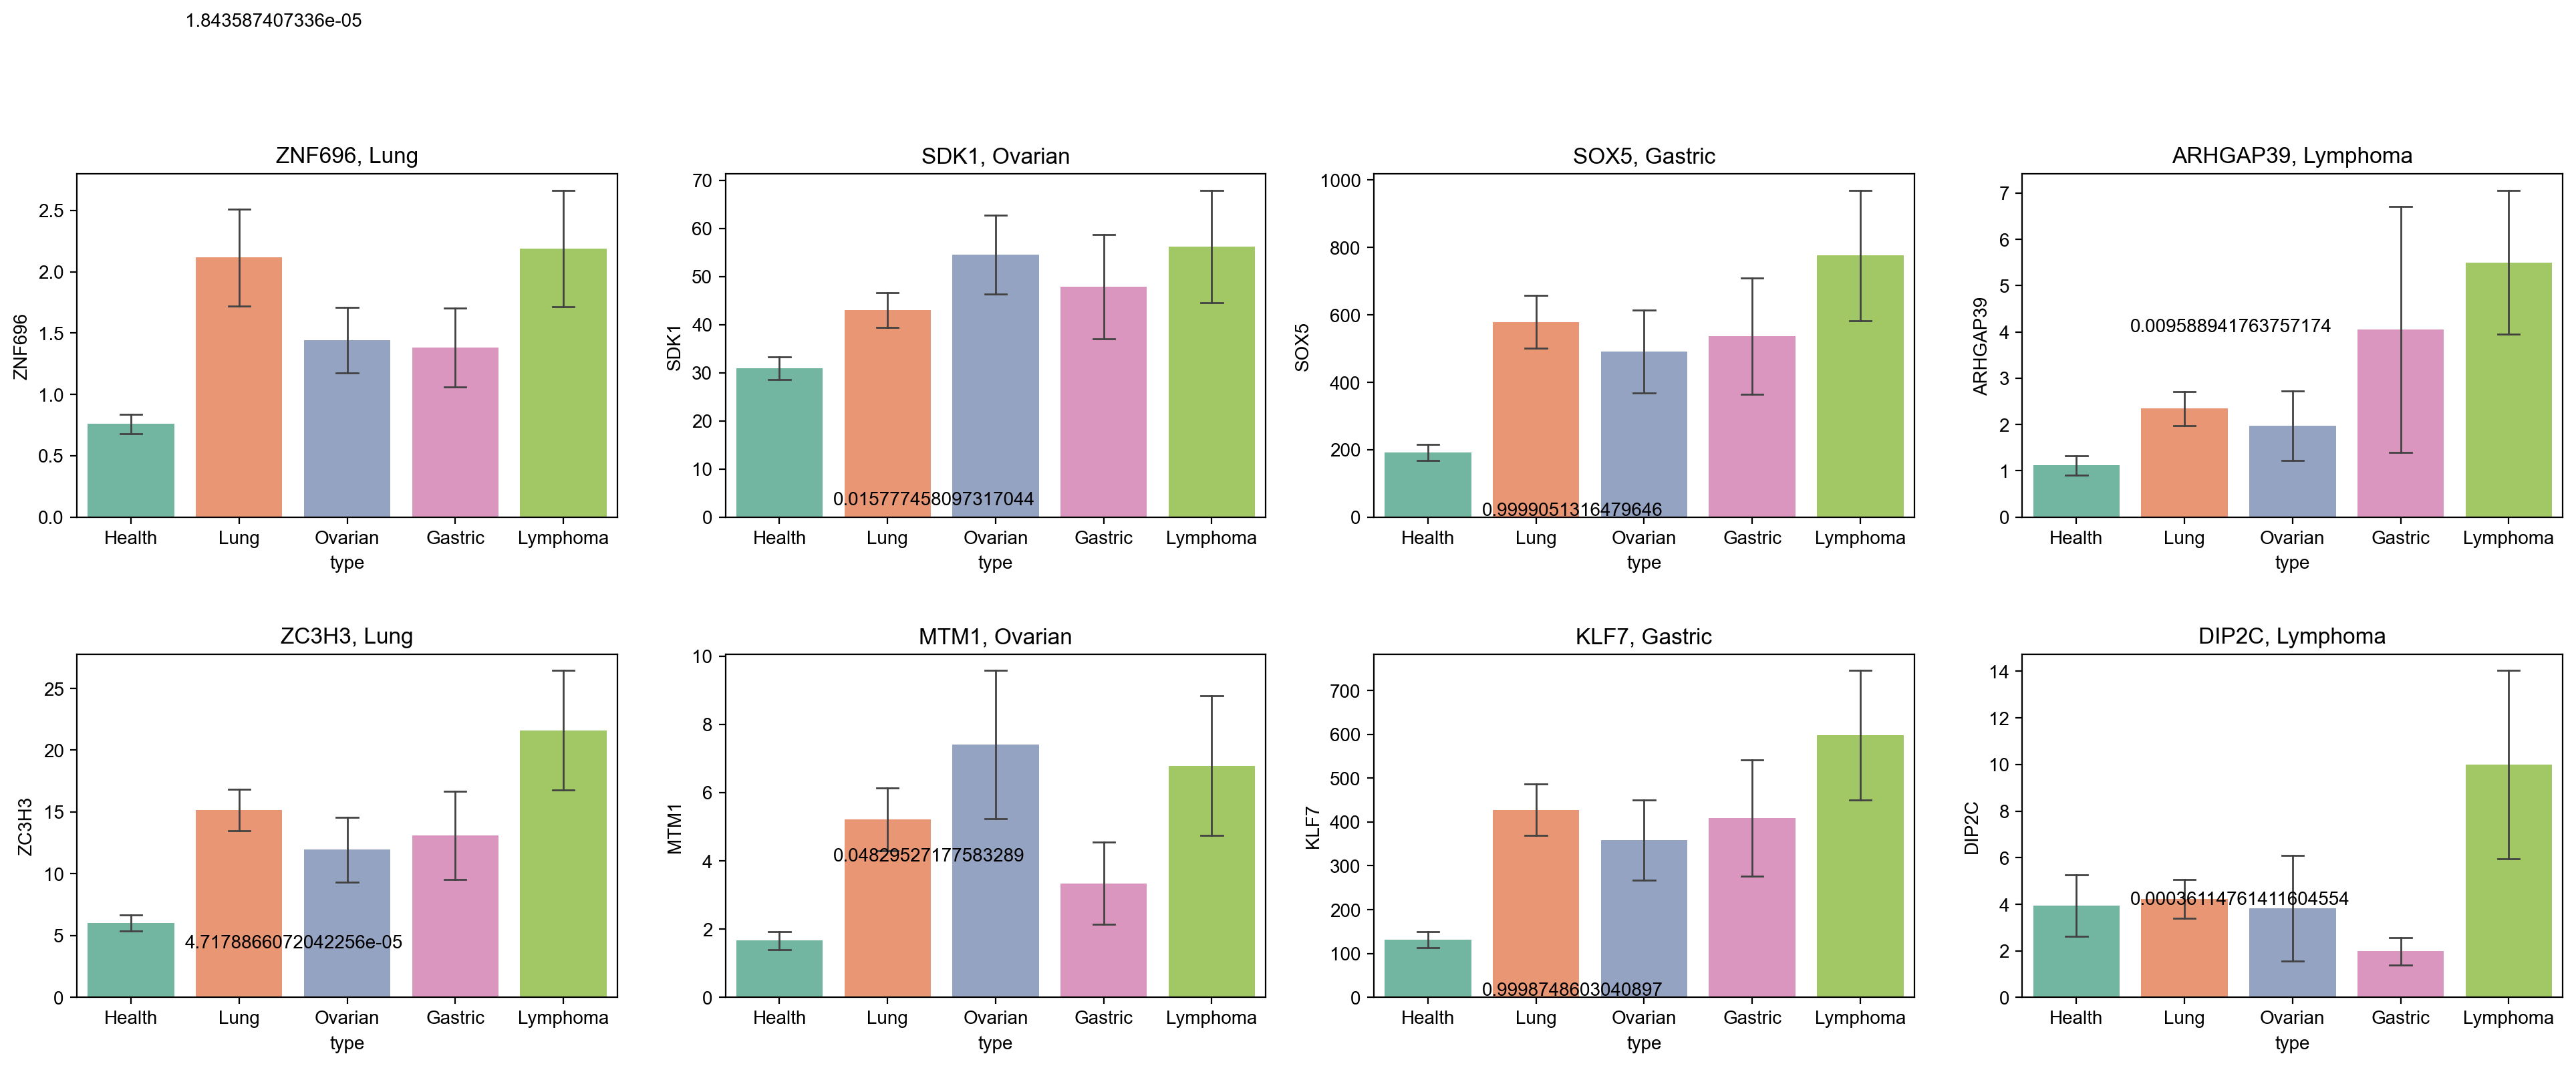

In [18]:
###基因表达分布可视化 使用boxplot(箱线图)+swarmplot(散点图),展示不同癌症类型中 特定基因的表达情况，并使用 Mann-Whitney U 检验 评估差异是否显著,boxplot换成barplot
%matplotlib inline
DataUse = df_filtered.T
Datainfo = sample_metadata.copy()
DataUse = DataUse.loc[Datainfo.index]
DataUse['type'] = Datainfo['ctype']
Data = DataUse

order = ['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma']
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
fig,axes = plt.subplots(ncols = 4, nrows = 2, figsize = (24, 8), )
plt.subplots_adjust(hspace = 0.4)

axes[0,0].set_title('ZNF696, Lung')
sns.barplot(x = "type", y = "ZNF696", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,0], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "ZNF696", data = Data, ax=axes[0,0], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Lung'].index, 'ZNF696'], Data.loc[Data[Data['type'] == 'Health'].index, 'ZNF696'], alternative = 'greater')
axes[0,0].text(0.5, 4, p)
axes[0,0].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[0,1].set_title('SDK1, Ovarian')
sns.barplot(x = "type", y = "SDK1", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,1], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "SDK1", data = Data, ax=axes[0,1], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Ovarian'].index, 'SDK1'], Data.loc[Data[Data['type'] == 'Health'].index, 'SDK1'], alternative = 'greater')
axes[0,1].text(0.5, 2.5, p)
axes[0,1].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[0,2].set_title('SOX5, Gastric')
sns.barplot(x = "type", y = "SOX5", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,2], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "SOX5", data = Data, ax=axes[0,2], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Gastric'].index, 'SOX5'], Data.loc[Data[Data['type'] == 'Health'].index, 'SOX5'], alternative = 'greater')
axes[0,2].text(0.5, 4, p)
axes[0,2].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[0,3].set_title('ARHGAP39, Lymphoma')
sns.barplot(x = "type", y = "ARHGAP39", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,3], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "ARHGAP39", data = Data, ax=axes[0,3], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Lymphoma'].index, 'ARHGAP39'], Data.loc[Data[Data['type'] == 'Health'].index, 'ARHGAP39'], alternative = 'greater')
axes[0,3].text(0.5, 4, p)
axes[0,3].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])


axes[1,0].set_title('ZC3H3, Lung')
sns.barplot(x = "type", y = "ZC3H3", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,0], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "ZC3H3", data = Data, ax=axes[1,0], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Lung'].index, 'ZC3H3'], Data.loc[Data[Data['type'] == 'Health'].index, 'ZC3H3'], alternative = 'greater')
axes[1,0].text(0.5, 4, p)
axes[1,0].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[1,1].set_title('MTM1, Ovarian')
sns.barplot(x = "type", y = "MTM1", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,1], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "MTM1", data = Data, ax=axes[1,1], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Ovarian'].index, 'MTM1'], Data.loc[Data[Data['type'] == 'Health'].index, 'MTM1'], alternative = 'greater')
axes[1,1].text(0.5, 4, p)
axes[1,1].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[1,2].set_title('KLF7, Gastric')
sns.barplot(x = "type", y = "KLF7", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,2], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "KLF7", data = Data, ax=axes[1,2], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Gastric'].index, 'KLF7'], Data.loc[Data[Data['type'] == 'Health'].index, 'KLF7'], alternative = 'greater')
axes[1,2].text(0.5, 4, p)
axes[1,2].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[1,3].set_title('DIP2C, Lymphoma')
sns.barplot(x = "type", y = "DIP2C", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,3], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "DIP2C", data = Data, ax=axes[1,3], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Lymphoma'].index, 'DIP2C'], Data.loc[Data[Data['type'] == 'Health'].index, 'DIP2C'], alternative = 'greater')
axes[1,3].text(0.5, 4, p)
axes[1,3].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/GeneExample1_barplot.pdf')
plt.show()

/tmp/ipykernel_131998/573007226.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "type", y = "MAGEA2", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,0], order = order, palette = palette)
/tmp/ipykernel_131998/573007226.py:15: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x = "type", y = "MAGEA2", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,0], order = order, palette = palette)
/tmp/ipykernel_131998/573007226.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])
/tmp/ipykernel_131998/573007226.py:24: FutureWarning: 

Passing `palette` without assigning `hue

0.009545431240230572
0.04625832460487483


/tmp/ipykernel_131998/573007226.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])
/tmp/ipykernel_131998/573007226.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "type", y = "SHANK3", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,0], order = order, palette = palette)
/tmp/ipykernel_131998/573007226.py:33: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x = "type", y = "SHANK3", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,0], order = order, palette = palette)
/tmp/ipykernel_131998/573007226.py:39: UserWarning: FixedFormatter should only be used together 

0.039999072745604006
0.017928328910472097


/tmp/ipykernel_131998/573007226.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])


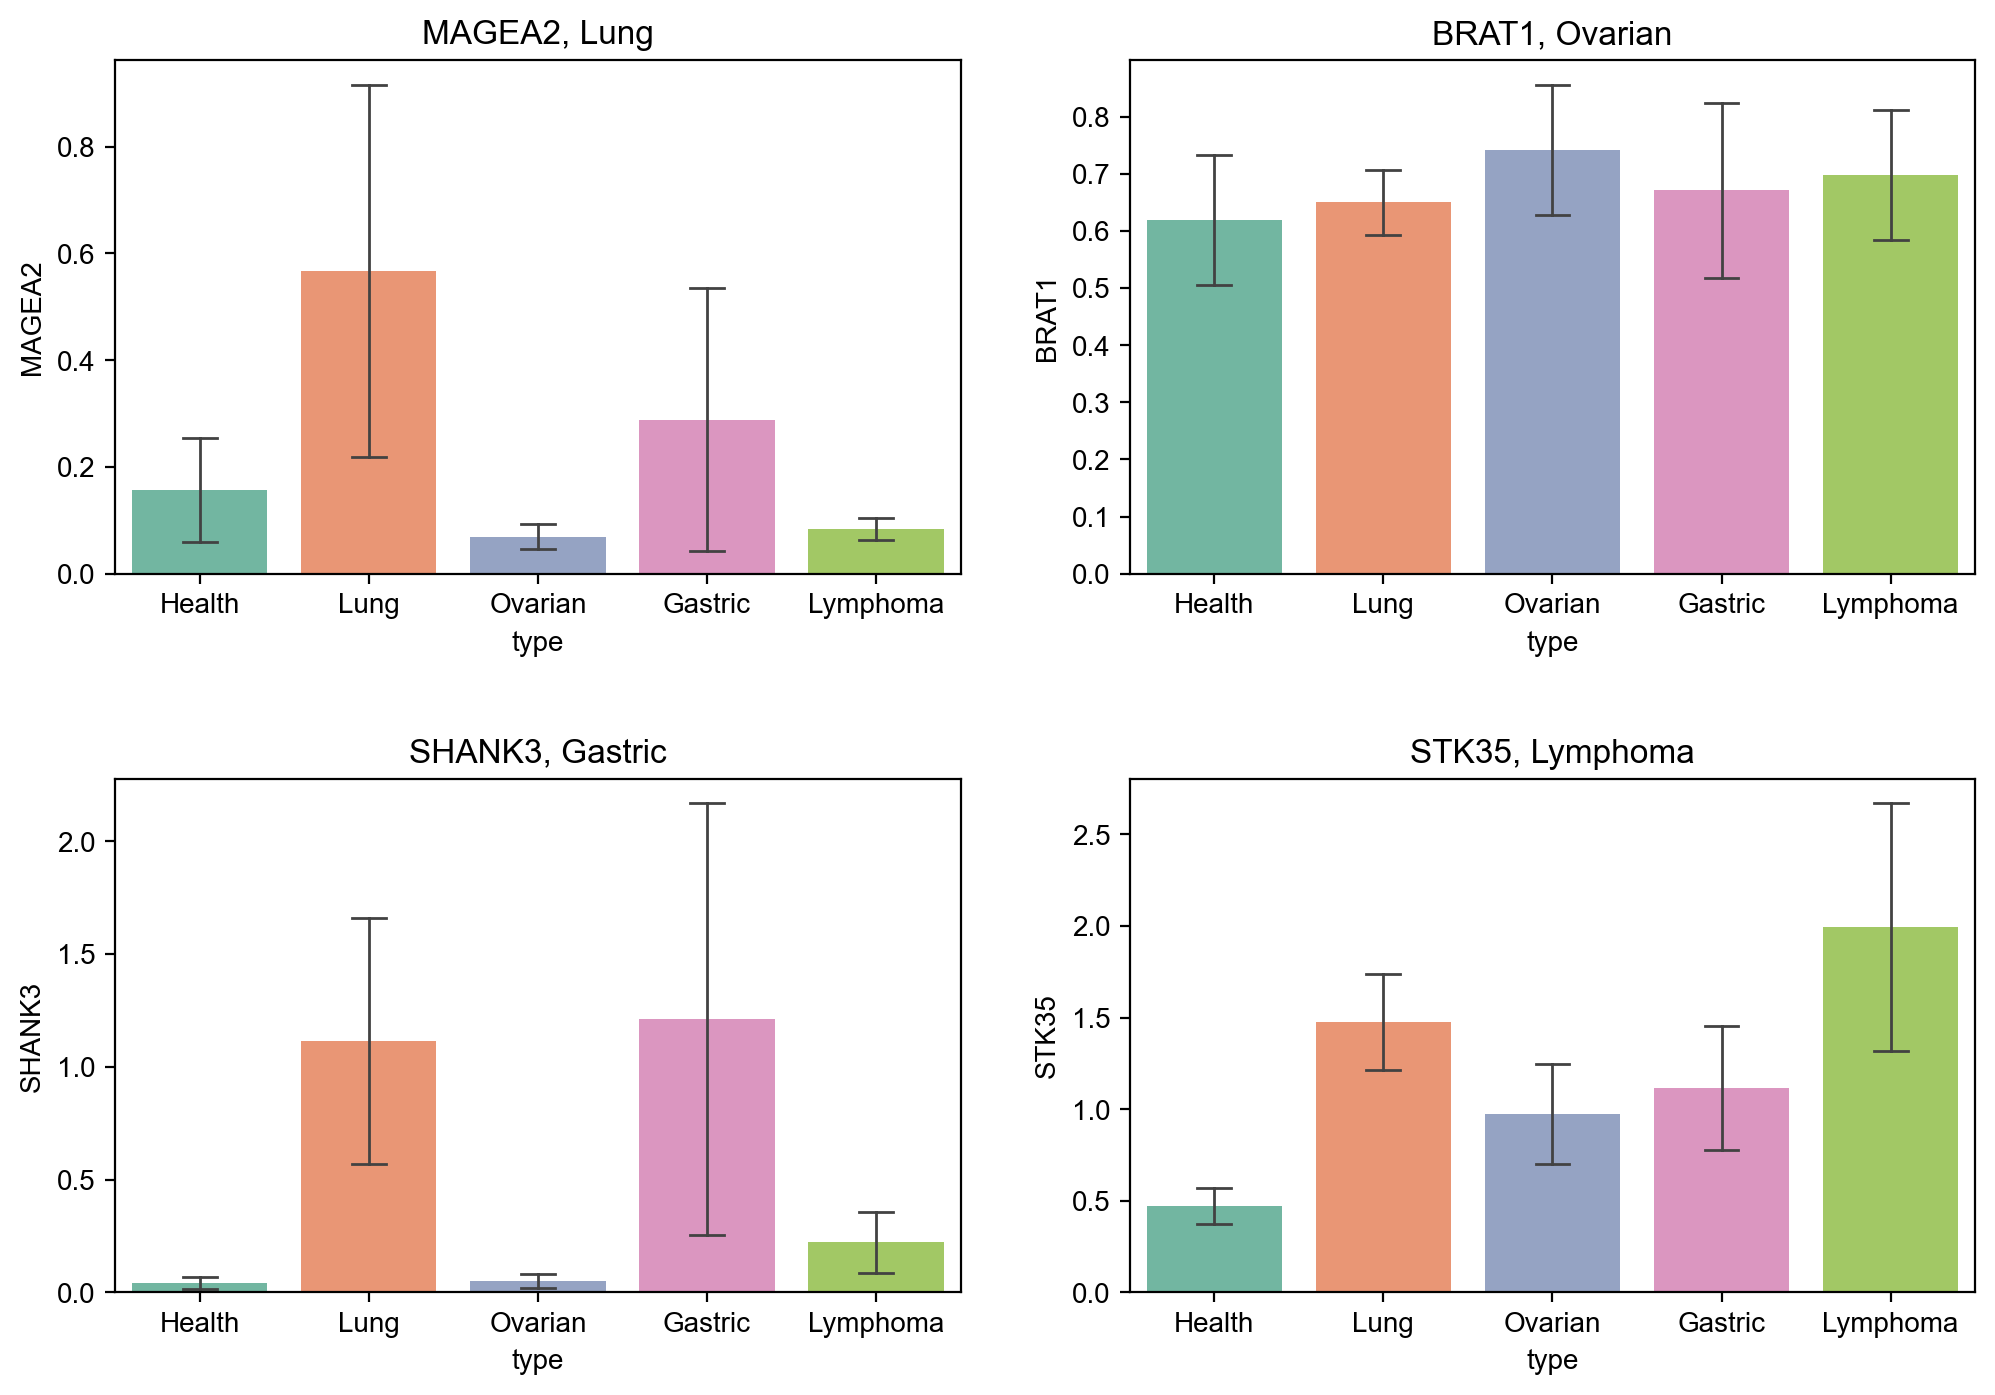

In [22]:
###基因表达分布可视化 使用boxplot(箱线图)+swarmplot(散点图),展示不同癌症类型中 特定基因的表达情况，并使用 Mann-Whitney U 检验 评估差异是否显著。
%matplotlib inline
DataUse = df_filtered.T
Datainfo = sample_metadata.copy()
DataUse = DataUse.loc[Datainfo.index]
DataUse['type'] = Datainfo['ctype']
Data = DataUse

order = ['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma']
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
fig,axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 8), )
plt.subplots_adjust(hspace = 0.4)

axes[0,0].set_title('MAGEA2, Lung')
sns.barplot(x = "type", y = "MAGEA2", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,0], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "ZNF696", data = Data, ax=axes[0,0], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Lung'].index, 'MAGEA2'], Data.loc[Data[Data['type'] == 'Health'].index, 'MAGEA2'], alternative = 'greater')
print(p)
#max_y = Data['MAGEA2'].max()
#axes[0,0].text(0.5, max_y * 1.05, f"{p:.4f}", ha='center')
axes[0,0].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[0,1].set_title('BRAT1, Ovarian')
sns.barplot(x = "type", y = "BRAT1", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[0,1], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "SDK1", data = Data, ax=axes[0,1], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Ovarian'].index, 'BRAT1'], Data.loc[Data[Data['type'] == 'Health'].index, 'BRAT1'], alternative = 'greater')
print(p)
#max_y = Data['BRAT1'].max()
#axes[0,1].text(0.5, max_y * 1.05, f"{p:.4f}", ha='center')
axes[0,1].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[1,0].set_title('SHANK3, Gastric')
sns.barplot(x = "type", y = "SHANK3", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,0], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "SOX5", data = Data, ax=axes[0,2], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Gastric'].index, 'SHANK3'], Data.loc[Data[Data['type'] == 'Health'].index, 'SHANK3'], alternative = 'greater')
print(p)
#max_y = Data['SHANK3'].max()
#axes[1,0].text(0.5, max_y * 1.05, f"{p:.4f}", ha='center')
axes[1,0].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

axes[1,1].set_title('STK35, Lymphoma')
sns.barplot(x = "type", y = "STK35", data = Data, errorbar='se', color = 'white', capsize=0.2, errwidth=1, ax=axes[1,1], order = order, palette = palette)
#sns.swarmplot(x = "type", y = "ARHGAP39", data = Data, ax=axes[0,3], order = order, palette = palette)
U1, p = mannwhitneyu(Data.loc[Data[Data['type'] == 'Lymphoma'].index, 'STK35'], Data.loc[Data[Data['type'] == 'Health'].index, 'STK35'], alternative = 'greater')
print(p)
#max_y = Data['STK35'].max()
#axes[1,1].text(0.5, max_y * 1.05, f"{p:.4f}", ha='center')
axes[1,1].set_xticklabels(['Health', 'Lung', 'Ovarian', 'Gastric', 'Lymphoma'])

#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/GeneExample_selected_barplot.pdf')
plt.show()